In [2]:
from ArticlesRep import MeanSimilarityoneindustry,MeanSimilaritytwoindustry #common function

import pandas as pd

import numpy as np

%matplotlib inline

import pickle

import visdom

from tqdm import tnrange, tqdm_notebook
from tqdm.autonotebook import tqdm
tqdm.pandas()

from time import time,sleep
from datetime import datetime

from sklearn.metrics.pairwise import cosine_similarity
# import visdom
# vis=visdom.Visdom()
# env="TagBased"

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning,)
# %matplotlib inline

import re

from pprint import pprint
#coding:utf-8
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
#有中文出现的情况，需要u'内容'
list_industry=["水泥","食品飲料","石化","紡織","電機機械","電器電纜","化學工業",
               "建材居家用品","造紙","鋼鐵金屬","車輛相關","科技相關","營建地產","運輸","觀光休閒娛樂",
               "金融相關","百貨通路","公用事業","控股","生技醫療保健","農林漁牧","航天軍工","能源","傳播出版","綜合",
               "傳產其他","其他","金屬礦採選",
              ]

In [3]:
from keras.layers import Dense,Lambda,Input,Dot,Add,Subtract,GaussianDropout
from keras.utils import Sequence,plot_model
from keras.models import Model,load_model
from keras import backend as K


Using TensorFlow backend.


### Denoising Autoencoder with weak supervision

In [4]:
# custommed function
def noisefunction(x):
    x_noise=K.ones_like(x)
    return K.in_train_phase(x_noise,x,1)

def tripletlossfunction(inputs):
    r01=inputs[0]
    r02=inputs[1]
    loss=K.log(1+K.exp(r02-r01))
#     x=np.array([[0],[1],[0],[1]])
#     x=K.variable(x)
    return loss

def losspassfunction(y_true,y_pred):
    return y_pred

def test(inputs):
#     x=K.dot(inputs,k.transpose(inputs))
    x=K.transpose(inputs)
    return x

In [5]:
x=Input(shape=(5,))
y=Lambda(noisefunction)(x)
model=Model(x,y)
x=np.arange(2*5).reshape((2,5))
model.predict(x)

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]], dtype=float32)

In [42]:
K.clear_session()
np.random.seed(100)
###############
# instantiate layer
# noise=Lambda(noisefunction,name="noisefunction")
# trilosslayer=Lambda(Triplet,name="trilosslayer")
# dense=Dense(units=12000,activation="sigmoid",name="Dense1")
###############
#parameter setting
BOW_dim=20000
DR_dim=100
loss_weights=[1,1,1,2]

##Encoder
x=Input((BOW_dim,),name="encoder_input")
# y=Lambda(noisefunction,name="noisefunction")
y=GaussianDropout(rate=0.2,name="noise")(x)
# y=Dense(30,use_bias=False)(y)
y=Dense(units=DR_dim,activation="sigmoid",name="Dense",use_bias=False)(y)
encoder=Model(x,y,name="encoder")

##Decoder
x=Input((DR_dim,),name="input") 
y=Dense(units=20000,activation="sigmoid",name="Dense")(x)
decoder=Model(x,y,name="decoder")

##Tripletloss
x0=Input((DR_dim,),name="anchor_input")
x1=Input((DR_dim,),name="positive_input")
x2=Input((DR_dim,),name="negative_input")
r01=Dot(axes=1,name="SimiPositive")([x0,x1])
r02=Dot(axes=1,name="SimiNegative")([x0,x2])
out=Lambda(tripletlossfunction,name="tripletlossfunction")([r01,r02])
tripletloss=Model(inputs=[x0,x1,x2],outputs=out,name="triplet")

#Build Tri-Autoencoder model
x0=Input((BOW_dim,),name="anchor_input")
x1=Input((BOW_dim,),name="positive_input")
x2=Input((BOW_dim,),name="negative_input")

h0=encoder(x0)
h1=encoder(x1)
h2=encoder(x2)

Lt=tripletloss([h0,h1,h2])

y0=decoder(h0)
y1=decoder(h1)
y2=decoder(h2)

y0=Lambda(lambda x :x ,name="anchor")(y0)
y1=Lambda(lambda x :x ,name="positive")(y1)
y2=Lambda(lambda x :x ,name="negative")(y2)

# triplet_loss

Tri_AutoEncoder=Model(inputs=[x0,x1,x2],outputs=[y0,y1,y2,Lt])
Tri_AutoEncoder.compile(optimizer="adam",
                        loss=['binary_crossentropy','binary_crossentropy','binary_crossentropy',losspassfunction],
                        loss_weights=loss_weights
                       )
#save initial model
Tri_AutoEncoder.save("Tri_AutoEncoder.initial.h5")
encoder.save("encoder.initial.h5")
decoder.save("decoder.initial.h5")
#plot
plot_model(Tri_AutoEncoder,to_file="Tri_DenoiseAutoEncoder.png")
plot_model(encoder,to_file="encoder.png")
plot_model(decoder,to_file="decoder.png")
# Open the file to record
with open('Tri_AutoEencoderncoder.summary.txt','w') as f:
    # Pass the file handle in as a lambda function to make it callable
    Tri_AutoEncoder.summary(print_fn=lambda x: f.write("    "+x + '\n'))
with open('encoder.summary.txt','w') as f:
    # Pass the file handle in as a lambda function to make it callable
    encoder.summary(print_fn=lambda x: f.write("    "+x + '\n'))
with open('decoder.summary.txt','w') as f:
    # Pass the file handle in as a lambda function to make it callable
    decoder.summary(print_fn=lambda x: f.write("    "+x + '\n'))

Tri_AutoEncoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       (None, 20000)        0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     (None, 20000)        0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     (None, 20000)        0                                            
__________________________________________________________________________________________________
encoder (Model)                 (None, 100)          2000000     anchor_input[0][0]               
                                                                 positive_input[0][0]             
          

## Load Data

In [9]:
Data=np.load("D:3.AutoencoderForArticle/BOW_binary_v01.npy")

In [10]:
with open("D:3.AutoencoderForArticle/train_dict_collect_small_industry","rb") as f:
    train_dict_collect_small_industry=pickle.load(f)

In [11]:
with open("D:3.AutoencoderForArticle/test_dict_collect_small_industry","rb") as f:
    test_dict_collect_small_industry=pickle.load(f)

## Data generator

In [13]:
class DataGenerator(Sequence):

    def __init__(self, tripletindex,Data, batch_size=32):
        self.tripletindex= np.asarray(tripletindex)
        pick=np.random.permutation(len(self.tripletindex))
        self.tripletindex= self.tripletindex[pick]
        self.batch_size = batch_size
        self.Data=Data

    def __len__(self):
         return int(np.ceil(self.tripletindex.shape[0] / float(self.batch_size)))
#         return 1
    def __getitem__(self, idx):
        batch_index = self.tripletindex[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_anchor = self.Data[batch_index[:,0]]
        batch_positive = self.Data[batch_index[:,1]]
        batch_negative = self.Data[batch_index[:,2]]
        tripletloss=np.zeros((batch_negative.shape[0],1))
        return [batch_anchor,batch_positive,batch_negative],[batch_anchor,batch_positive,batch_negative,tripletloss]
    def on_epoch_end(self):
        """Method called at the end of every epoch.
        """
        pick=np.random.permutation(len(self.tripletindex))
        self.tripletindex= self.tripletindex[pick]
        

In [14]:
class HardTriGenerator(Sequence):

    def __init__(self, dict_id_news,Data, P=4,K=8):
        self.dict_id_news=dict_id_news
        self.industry=np.asarray(list(dict_id_news.keys()))
#         pick=np.random.permutation(len(self.tripletindex))
#         self.tripletindex= self.tripletindex[pick]
        self.P=P
        self.K=K
        self.Data=Data

    def __len__(self):
        return int(np.ceil(len(self.industry) / self.P))
#         return 1
    def __getitem__(self, idx):
        indusrty= self.industry[idx*self.P:(idx+1)*self.P]
        small_dict_id_news={i:np.random.choice(self.dict_id_news[i],size=self.K,replace=False) for i in indusrty}
        dict_small_triplet=dict()
        for k in small_dict_id_news:
            poslist=small_dict_id_news[k]
            poslen=len(poslist)
            neglist=[]
            for j in small_dict_id_news:
                if k!=j:neglist+=train_dict_collect_small_industry[j]
                neglen=len(neglist)
            indarray=np.zeros((int(poslen*(poslen-1)*neglen/2),3),dtype=int)
            i=0
            for ip1_,a in enumerate(poslist):
                for ip2_,p in enumerate(poslist[ip1_+1:]):
                    for in_,n in enumerate(neglist):
        #                 print(p1,p2,n)
                        indarray[i,0]=a
                        indarray[i,1]=p
                        indarray[i,2]=n
                        i+=1
        #                 break
        #             break
        #         break
            dict_small_triplet[k]=indarray            
        for i,k in enumerate(dict_small_triplet):
            if i==0:tripletindex=dict_small_triplet[k]
            else:tripletindex=np.concatenate((tripletindex,dict_small_triplet[k]),axis=0)   
        batch_anchor=self.Data[tripletindex[:,0]]
        batch_positive=self.Data[tripletindex[:,1]]
        batch_negative=self.Data[tripletindex[:,2]]
        tripletloss=np.zeros((batch_negative.shape[0],1))    
        
        return [batch_anchor,batch_positive,batch_negative],[batch_anchor,batch_positive,batch_negative,tripletloss]
    def on_epoch_end(self):
        """Method called at the end of every epoch.
        """
        self.industry=np.random.permutation(self.industry)       

In [50]:
#setup

#instantiate generator
traingenerator=HardTriGenerator(dict_id_news=train_dict_collect_small_industry,
                                Data=Data,
                                P=3,
                                K=3,
                               )
testgenerator=HardTriGenerator(dict_id_news=test_dict_collect_small_industry,
                               Data=Data,P=3,K=3,
                              )

Wall time: 0 ns


In [67]:
Tri_AutoEncoder=load_model("Tri_AutoEncoder.initial.h5",custom_objects={"losspassfunction":losspassfunction})

## Train

In [68]:
#setup
epochs=200
# steps_per_epoch=5
#train
History=Tri_AutoEncoder.fit_generator(generator=traingenerator,
#                                       shuffle=True,
                                      epochs=epochs,
#                                       steps_per_epoch=steps_per_epoch,
                                      validation_data=testgenerator,
                                      verbose=2,
                                      workers=1,use_multiprocessing=False,
                                    
                                     )
#save model
Tri_AutoEncoder.save("Tri_AutoEncoder_trained.h5")
encoder.save("encoder_trained.h5")
decoder.save("decoder_trained.h5")

Epoch 1/200
 - 21s - loss: 2.9398 - anchor_loss: 0.6807 - positive_loss: 0.6807 - negative_loss: 0.6805 - triplet_loss: 0.8979 - val_loss: 2.7911 - val_anchor_loss: 0.6495 - val_positive_loss: 0.6496 - val_negative_loss: 0.6499 - val_triplet_loss: 0.8421
Epoch 2/200
 - 20s - loss: 2.5778 - anchor_loss: 0.6372 - positive_loss: 0.6367 - negative_loss: 0.6381 - triplet_loss: 0.6658 - val_loss: 2.4431 - val_anchor_loss: 0.6110 - val_positive_loss: 0.6086 - val_negative_loss: 0.6119 - val_triplet_loss: 0.6116
Epoch 3/200
 - 20s - loss: 3.1077 - anchor_loss: 0.6030 - positive_loss: 0.6021 - negative_loss: 0.6004 - triplet_loss: 1.3023 - val_loss: 2.3890 - val_anchor_loss: 0.5729 - val_positive_loss: 0.5697 - val_negative_loss: 0.5759 - val_triplet_loss: 0.6705
Epoch 4/200
 - 20s - loss: 3.0468 - anchor_loss: 0.5607 - positive_loss: 0.5675 - negative_loss: 0.5661 - triplet_loss: 1.3524 - val_loss: 2.6439 - val_anchor_loss: 0.5507 - val_positive_loss: 0.5411 - val_negative_loss: 0.5451 - val_t

Epoch 33/200
 - 21s - loss: 2.3223 - anchor_loss: 0.1602 - positive_loss: 0.1769 - negative_loss: 0.1744 - triplet_loss: 1.8108 - val_loss: 1.3242 - val_anchor_loss: 0.1502 - val_positive_loss: 0.1387 - val_negative_loss: 0.1688 - val_triplet_loss: 0.8664
Epoch 34/200
 - 20s - loss: 3.0734 - anchor_loss: 0.1851 - positive_loss: 0.1984 - negative_loss: 0.1706 - triplet_loss: 2.5193 - val_loss: 1.3691 - val_anchor_loss: 0.1362 - val_positive_loss: 0.1336 - val_negative_loss: 0.1667 - val_triplet_loss: 0.9326
Epoch 35/200
 - 20s - loss: 2.1470 - anchor_loss: 0.1611 - positive_loss: 0.1590 - negative_loss: 0.1667 - triplet_loss: 1.6601 - val_loss: 2.1326 - val_anchor_loss: 0.1629 - val_positive_loss: 0.1625 - val_negative_loss: 0.1660 - val_triplet_loss: 1.6411
Epoch 36/200
 - 20s - loss: 1.5192 - anchor_loss: 0.1517 - positive_loss: 0.1319 - negative_loss: 0.1636 - triplet_loss: 1.0720 - val_loss: 2.6399 - val_anchor_loss: 0.1934 - val_positive_loss: 0.1836 - val_negative_loss: 0.1627 - v

Epoch 65/200
 - 21s - loss: 2.1172 - anchor_loss: 0.1188 - positive_loss: 0.1281 - negative_loss: 0.1221 - triplet_loss: 1.7483 - val_loss: 1.0930 - val_anchor_loss: 0.1080 - val_positive_loss: 0.0861 - val_negative_loss: 0.1241 - val_triplet_loss: 0.7749
Epoch 66/200
 - 21s - loss: 1.4226 - anchor_loss: 0.1089 - positive_loss: 0.0986 - negative_loss: 0.1220 - triplet_loss: 1.0931 - val_loss: 1.3950 - val_anchor_loss: 0.0953 - val_positive_loss: 0.0974 - val_negative_loss: 0.1195 - val_triplet_loss: 1.0829
Epoch 67/200
 - 21s - loss: 1.7937 - anchor_loss: 0.1342 - positive_loss: 0.1190 - negative_loss: 0.1215 - triplet_loss: 1.4191 - val_loss: 1.6131 - val_anchor_loss: 0.0851 - val_positive_loss: 0.1040 - val_negative_loss: 0.1181 - val_triplet_loss: 1.3058
Epoch 68/200
 - 21s - loss: 1.4523 - anchor_loss: 0.1171 - positive_loss: 0.0941 - negative_loss: 0.1204 - triplet_loss: 1.1206 - val_loss: 1.4219 - val_anchor_loss: 0.1259 - val_positive_loss: 0.1029 - val_negative_loss: 0.1239 - v

Epoch 97/200
 - 20s - loss: 1.4363 - anchor_loss: 0.1060 - positive_loss: 0.0995 - negative_loss: 0.1012 - triplet_loss: 1.1296 - val_loss: 1.0883 - val_anchor_loss: 0.0768 - val_positive_loss: 0.0851 - val_negative_loss: 0.0963 - val_triplet_loss: 0.8301
Epoch 98/200
 - 20s - loss: 1.4785 - anchor_loss: 0.1039 - positive_loss: 0.1035 - negative_loss: 0.0997 - triplet_loss: 1.1714 - val_loss: 0.8332 - val_anchor_loss: 0.0872 - val_positive_loss: 0.0735 - val_negative_loss: 0.0959 - val_triplet_loss: 0.5767
Epoch 99/200
 - 21s - loss: 1.3004 - anchor_loss: 0.1072 - positive_loss: 0.1074 - negative_loss: 0.0976 - triplet_loss: 0.9883 - val_loss: 1.4554 - val_anchor_loss: 0.1104 - val_positive_loss: 0.1066 - val_negative_loss: 0.0998 - val_triplet_loss: 1.1387
Epoch 100/200
 - 20s - loss: 1.0556 - anchor_loss: 0.0963 - positive_loss: 0.0780 - negative_loss: 0.0982 - triplet_loss: 0.7831 - val_loss: 0.8704 - val_anchor_loss: 0.0707 - val_positive_loss: 0.0685 - val_negative_loss: 0.0951 - 

Epoch 129/200
 - 21s - loss: 1.0998 - anchor_loss: 0.0796 - positive_loss: 0.0770 - negative_loss: 0.0813 - triplet_loss: 0.8618 - val_loss: 1.2820 - val_anchor_loss: 0.0754 - val_positive_loss: 0.0711 - val_negative_loss: 0.0780 - val_triplet_loss: 1.0575
Epoch 130/200
 - 20s - loss: 0.8163 - anchor_loss: 0.1001 - positive_loss: 0.0690 - negative_loss: 0.0805 - triplet_loss: 0.5667 - val_loss: 1.4950 - val_anchor_loss: 0.0542 - val_positive_loss: 0.0792 - val_negative_loss: 0.0780 - val_triplet_loss: 1.2837
Epoch 131/200
 - 21s - loss: 0.6483 - anchor_loss: 0.0733 - positive_loss: 0.0688 - negative_loss: 0.0802 - triplet_loss: 0.4261 - val_loss: 1.1345 - val_anchor_loss: 0.0796 - val_positive_loss: 0.0749 - val_negative_loss: 0.0753 - val_triplet_loss: 0.9047
Epoch 132/200
 - 20s - loss: 1.5606 - anchor_loss: 0.0653 - positive_loss: 0.0930 - negative_loss: 0.0794 - triplet_loss: 1.3229 - val_loss: 0.6869 - val_anchor_loss: 0.0651 - val_positive_loss: 0.0644 - val_negative_loss: 0.0748

Epoch 161/200
 - 20s - loss: 0.8355 - anchor_loss: 0.0486 - positive_loss: 0.0674 - negative_loss: 0.0648 - triplet_loss: 0.6547 - val_loss: 0.6201 - val_anchor_loss: 0.0553 - val_positive_loss: 0.0535 - val_negative_loss: 0.0639 - val_triplet_loss: 0.4474
Epoch 162/200
 - 20s - loss: 0.8337 - anchor_loss: 0.0870 - positive_loss: 0.0572 - negative_loss: 0.0639 - triplet_loss: 0.6255 - val_loss: 0.4308 - val_anchor_loss: 0.0521 - val_positive_loss: 0.0519 - val_negative_loss: 0.0634 - val_triplet_loss: 0.2634
Epoch 163/200
 - 20s - loss: 1.1804 - anchor_loss: 0.0627 - positive_loss: 0.0738 - negative_loss: 0.0637 - triplet_loss: 0.9801 - val_loss: 1.1213 - val_anchor_loss: 0.0439 - val_positive_loss: 0.0572 - val_negative_loss: 0.0615 - val_triplet_loss: 0.9587
Epoch 164/200
 - 20s - loss: 0.6185 - anchor_loss: 0.0583 - positive_loss: 0.0513 - negative_loss: 0.0637 - triplet_loss: 0.4452 - val_loss: 0.7923 - val_anchor_loss: 0.0401 - val_positive_loss: 0.0581 - val_negative_loss: 0.0614

Epoch 193/200
 - 20s - loss: 0.9326 - anchor_loss: 0.0416 - positive_loss: 0.0572 - negative_loss: 0.0514 - triplet_loss: 0.7825 - val_loss: 0.5820 - val_anchor_loss: 0.0433 - val_positive_loss: 0.0355 - val_negative_loss: 0.0475 - val_triplet_loss: 0.4556
Epoch 194/200
 - 20s - loss: 0.6571 - anchor_loss: 0.0379 - positive_loss: 0.0432 - negative_loss: 0.0512 - triplet_loss: 0.5248 - val_loss: 0.8147 - val_anchor_loss: 0.0600 - val_positive_loss: 0.0375 - val_negative_loss: 0.0517 - val_triplet_loss: 0.6656
Epoch 195/200
 - 20s - loss: 0.7463 - anchor_loss: 0.0555 - positive_loss: 0.0514 - negative_loss: 0.0506 - triplet_loss: 0.5888 - val_loss: 0.6499 - val_anchor_loss: 0.0403 - val_positive_loss: 0.0410 - val_negative_loss: 0.0470 - val_triplet_loss: 0.5217
Epoch 196/200
 - 20s - loss: 0.6798 - anchor_loss: 0.0539 - positive_loss: 0.0440 - negative_loss: 0.0500 - triplet_loss: 0.5319 - val_loss: 0.5953 - val_anchor_loss: 0.0408 - val_positive_loss: 0.0432 - val_negative_loss: 0.0482

In [71]:
df=pd.DataFrame(History.history)
df.to_hdf("history.h5",key="data")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023C999F50F0>,
      dtype=object)

C:\Users\garyyu\AppData\Local\Continuum\anaconda3\envs\deeplearningcpu\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


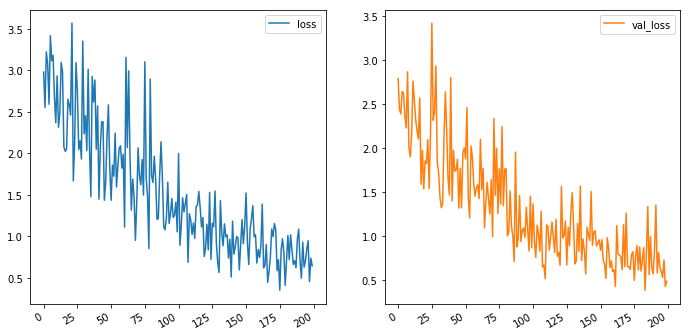

In [74]:
df[["loss","val_loss"]].plot(subplots=True,layout=(1,3),figsize=(18,6))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023C96FC96D8>,
      dtype=object)

C:\Users\garyyu\AppData\Local\Continuum\anaconda3\envs\deeplearningcpu\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


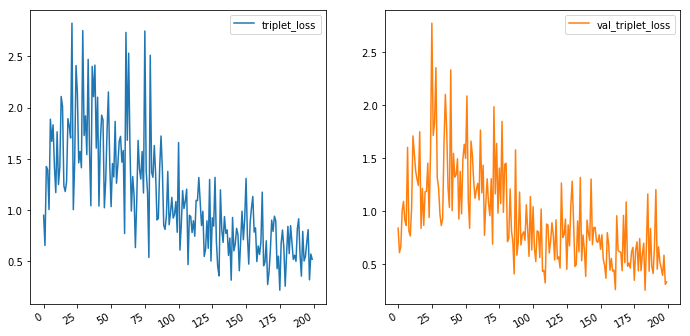

In [75]:
df[["triplet_loss","val_triplet_loss"]].plot(subplots=True,layout=(1,3),figsize=(18,6))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023C99E7C828>,
      dtype=object)

C:\Users\garyyu\AppData\Local\Continuum\anaconda3\envs\deeplearningcpu\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


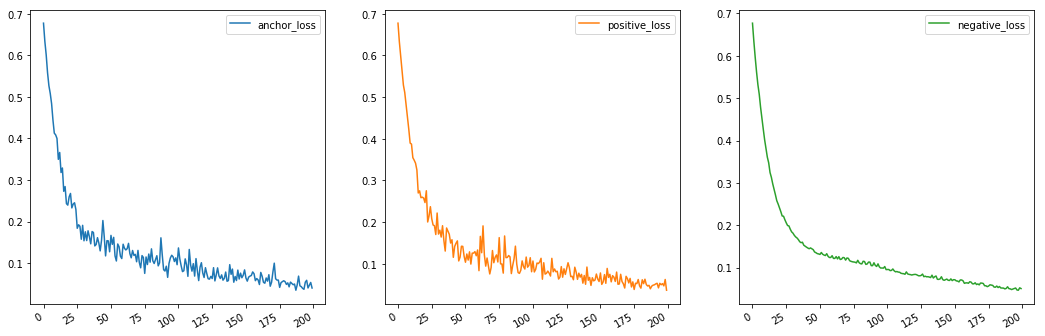

In [76]:
df[["anchor_loss","positive_loss","negative_loss"]].plot(subplots=True,layout=(1,3),figsize=(18,6))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023C99C38588>,
      dtype=object)

C:\Users\garyyu\AppData\Local\Continuum\anaconda3\envs\deeplearningcpu\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


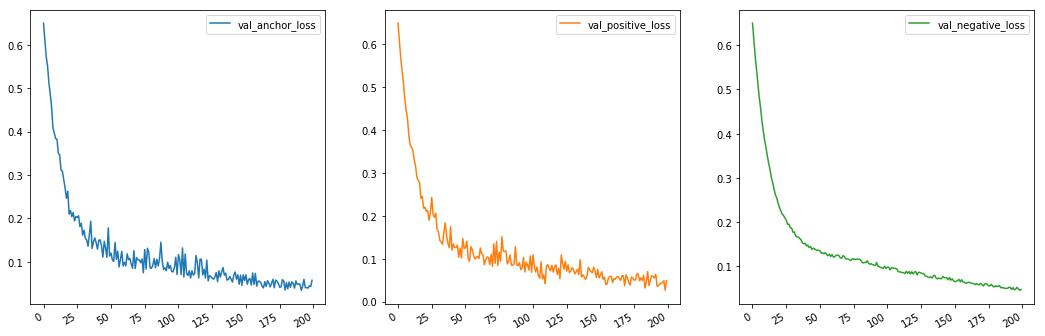

In [77]:
df[["val_anchor_loss","val_positive_loss","val_negative_loss"]].plot(subplots=True,layout=(1,3),figsize=(18,6))

In [199]:
import keras
print(keras.__version__)

2.2.4
